<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/Faiss_clsutering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
#!pip install faiss-gpu
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 9.5 MB/s 


In [4]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2023-01-03 07:17:28--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving sourceforge.net (sourceforge.net)... 104.18.11.128, 104.18.10.128, 2606:4700::6812:a80, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.11.128|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/ [following]
--2023-01-03 07:17:28--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download [following]
--2023-01-03 07:17:28--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting r

In [5]:
import faiss
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import talib as ta
import math
import scipy
from scipy import fftpack, signal
from sklearn.preprocessing import MinMaxScaler


In [6]:
class MarketData:
    @classmethod
    def initialize(cls, terms, sampling_window, data_length):
        cls.terms = terms
        cls.sampling_window = sampling_window
        cls.data_length = data_length
        cls.df = pd.DataFrame()
        cls.ts = []
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.vol = []
        cls.__read_data()
        cls.logopen = list(np.log(cls.open))
        cls.loghigh = list(np.log(cls.high))
        cls.loglow = list(np.log(cls.low))
        cls.logclose = list(np.log(cls.close))
        cls.close_change_ratio = list(np.array(pd.DataFrame(cls.close).pct_change().values.tolist()).reshape(len(cls.close)))
        cls.logclose_change_ratio = list(np.array(pd.DataFrame(cls.logclose).pct_change().values.tolist()).reshape(len(cls.logclose)))
        cls.ma_kairi = {}
        cls.rsi = {}
        cls.williams_R = {}
        cls.macd = {}
        cls.aroon_os = {}
        cls.cci = {}
        cls.dx = {}
        cls.stochastic = {}
        cls.cmo = {}
        cls.adxr = {}
        cls.apo = {}
        cls.plus_minus_di = {}
        cls.ppo = {}
        cls.ultosc = {}
        cls.__calc_index()

        cls.sampled_ts = []
        cls.std = []
        cls.skew = []
        cls.kurtosis = []
        cls.mean = []
        cls.median = []
        cls.mode = []
        cls.max_min_ratio = []
        cls.total_change_ratio = []
        cls.period_change_ratio = []
        cls.max_end_ratio = []
        cls.min_end_ratio = []
        cls.sampled_data = []
        cls.__get_sampling_data()
        
    
    @classmethod
    def __read_data(cls):
        cls.df = pd.read_csv('/content/drive/My Drive/BTC-PERP-1mcp.csv')
        cls.ts = list(cls.df['ts'])
        cls.open = list(cls.df['open'])
        cls.high = list(cls.df['high'])
        cls.low = list(cls.df['low'])
        cls.close = list(cls.df['close'])
        cls.vol = list(cls.df['volume'])

    @classmethod
    def __calc_index(cls):
        for term in cls.terms:
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)
            cls.rsi[term] = cls.__calc_rsi(term)
            cls.williams_R[term] = cls.__calc_williams_R(term)
            cls.macd[term] = cls.__calc_macdfix(term)
            cls.aroon_os[term] = cls.__calc_aroon_os(term)
            cls.cci[term] = cls.__calc_cci(term)
            cls.dx[term] = cls.__calc_dx(term)
            cls.stochastic[term] = cls.__calc_stochastic(term)
            cls.cmo[term] = cls.__calc_cmo(term)
            cls.adxr[term] = cls.__calc_adxr(term)
            cls.apo[term] = cls.__calc_apo(term)
            cls.plus_minus_di[term] = cls.__calc_plus_minus_di(term)
            cls.ppo[term] = cls.__calc_ppo(term)
            cls.ultosc[term] = cls.__calc_ultosc(term)


    @classmethod
    def __get_sampling_data(cls):
        count = 0
        current_start = 0
        while True:
            data = cls.close[current_start : current_start + cls.data_length]
            change_ratio = data / np.roll(data, 1)
            change_ratio = change_ratio[1:]
            maxv = max(data)
            minv = min(data)
            cls.sampled_ts.append(cls.ts[current_start + cls.data_length - 1])
            cls.mean.append(np.mean(change_ratio))
            cls.std.append(np.std(change_ratio))
            cls.skew.append(scipy.stats.skew(change_ratio))
            cls.kurtosis.append(scipy.stats.kurtosis(change_ratio))
            cls.mode.append(scipy.stats.mode(change_ratio)[0])
            cls.max_min_ratio.append(maxv / minv)
            cls.period_change_ratio.append(data[-1] / data[0])
            cls.total_change_ratio.append(100 * np.mean(np.diff(data) / np.mean(data)))
            cls.max_end_ratio.append(data[-1] / maxv)
            cls.max_end_ratio.append(data[-1] / minv)
            current_start += cls.sampling_window
            if current_start + cls.data_length >= len(cls.close):
                break
        for i in range(len(cls.sampled_ts)):
            cls.sampled_data.append([cls.mean[i], cls.std[i], cls.skew[i], cls.kurtosis[i], cls.mode[i], cls.max_min_ratio[i],
                                     cls.period_change_ratio[i], cls.total_change_ratio[i], cls.max_end_ratio[i],
                                     cls.max_end_ratio[i]])


    @classmethod
    def __calc_ma_kairi(cls, term):
        ma = list(ta.MA(np.array(cls.close, dtype='f8'), timeperiod=term))
        return list(map(lambda c, e: (c - e) / e, np.array(cls.close, dtype='f8'), np.array(ma, dtype='f8')))
    
    @classmethod
    def __calc_rsi(cls, term):
        return ta.RSI(np.array(cls.logclose, dtype='f8'), timeperiod=term)
    
    @classmethod
    def __calc_williams_R(cls, term):
        return list(ta.WILLR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'),timeperiod=term))
        
    @classmethod
    def __calc_macdfix(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.logclose, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'), np.array(signalperiod, dtype='i8'))
        return macd

    @classmethod
    def __calc_aroon_os(cls, term):
        return list(ta.AROONOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_cci(cls, term):
        return list(ta.CCI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_dx(cls, term):
        return list(ta.DX(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_stochastic(cls, term):
        k_term = term
        d_term = int(term / 2.0)
        fastk, fastd = ta.STOCHF(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), fastk_period=k_term, fastd_period=d_term, fastd_matype=0)
        return list(np.array(fastk) / np.array(fastd))


    @classmethod
    def __calc_cmo(cls, term):
        return list(ta.CMO(np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_adxr(cls, term):
        return ta.ADXR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)

    @classmethod
    def __calc_apo(cls, term):
        fperiod=term
        speriod=term * 2
        return ta.APO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_plus_minus_di(cls, term):
        mdi = ta.MINUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        pdi = ta.PLUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        return list(np.array(mdi) / np.array(pdi))

    @classmethod
    def __calc_ppo(cls, term):
        fperiod = term
        speriod = term * 2
        return ta.PPO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_ultosc(cls, term):
        p2 = int(term / 2.0)
        p1 = int(term / 3.0)
        return ta.ULTOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod1=p1, timeperiod2=p2, timeperiod3=term)

sampling_window = 60
data_length = 60
MarketData.initialize([30, 60], sampling_window, data_length)

In [15]:
np.array(MarketData.sampled_data).shape

<ipython-input-15-794cbae6a03e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(MarketData.sampled_data).shape


(23895, 10)

In [3]:
############################################################################
###################################### Generate test data ######################################
############################################################################

d = 64                           # dimension
nb = 100000                      # database size
nq = 10000                       # nb of queries
np.random.seed(1234)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

index = faiss.IndexFlatL2(d)   # build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)

True
100000


In [18]:
###############################################################################################
###################################### neighbor search #########################################################
###############################################################################################
k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(xb[:5], k) # sanity check, D= distance, I = index
print(I)
print(D)
D, I = index.search(xq, k)     # actual search
print(I[:5])                   # neighbors of the 5 first queries
print(I[-5:])                  # neighbors of the 5 last queries

[[  0 393 363  78]
 [  1 555 277 364]
 [  2 304 101  13]
 [  3 173  18 182]
 [  4 288 370 531]]
[[0.        7.1751738 7.20763   7.2511625]
 [0.        6.3235645 6.684581  6.799946 ]
 [0.        5.7964087 6.391736  7.2815123]
 [0.        7.2779055 7.527987  7.6628466]
 [0.        6.7638035 7.2951202 7.3688145]]
[[ 381  207  210  477]
 [ 526  911  142   72]
 [ 838  527 1290  425]
 [ 196  184  164  359]
 [ 526  377  120  425]]
[[ 9900 10500  9309  9831]
 [11055 10895 10812 11321]
 [11353 11103 10164  9787]
 [10571 10664 10632  9638]
 [ 9628  9554 10036  9582]]


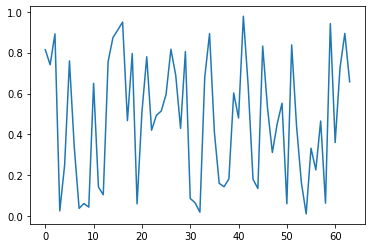

In [16]:
###############################################################################################
###################################### k-mean #########################################################
###############################################################################################

ncentroids = 1024
niter = 20
verbose = True
d = x.shape[1]
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(x)

In [43]:
class FaissKMeans:
    def __init__(self, n_clusters=4, n_init=2000, max_iter=300, random_state=42):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.seed = random_state
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None
 

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
            k=self.n_clusters,
            niter=self.max_iter,
            nredo=self.n_init,
            seed=self.seed)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]
        self.labels_ = self.kmeans.index.search(X.astype(np.float32), 1)[1].reshape(-1,)
        

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]
    

fm = FaissKMeans(6, 1000, 100, 42)
fm.fit(np.array(MarketData.sampled_data))

<ipython-input-43-5a3f346cb1bf>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fm.fit(np.array(MarketData.sampled_data))


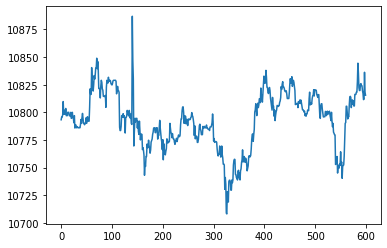

In [56]:
#plt.plot(fm.labels_[:10])
plt.plot(MarketData.close[:600])
#1564850760000

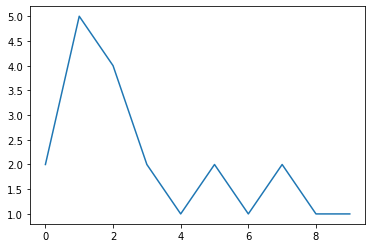

In [57]:
plt.plot(fm.labels_[:10])

In [47]:
###############################################################################################
###################################### PCA #####################################################
###############################################################################################
pca = faiss.PCAMatrix(np.array(MarketData.sampled_data).shape[-1], 2)
pca.train(np.array(MarketData.sampled_data))
tr = pca.apply_py(np.array(MarketData.sampled_data))
print(tr)

<ipython-input-47-5efa0f6f5741>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pca = faiss.PCAMatrix(np.array(MarketData.sampled_data).shape[-1], 2)
<ipython-input-47-5efa0f6f5741>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pca.train(np.array(MarketData.sampled_data))
<ipython-input-47-5efa0f6f5741>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when 

[[  0.0161972  -0.5261347]
 [ -2.878787    1.2545612]
 [-15.778654   -2.0887012]
 ...
 [ -7.69747     1.6600757]
 [  2.1642375  -0.512674 ]
 [ -1.1114049  -1.4005206]]


        PC1       PC2       PC3       PC4      PC5       PC6       PC7  \
0  0.331298  0.250541  0.199993  0.099105  0.08412  0.027419  0.007369   

       PC8       PC9          PC10  
0  0.00013  0.000025  2.705194e-33  


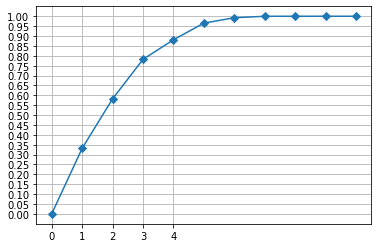

In [18]:
from sklearn.decomposition import PCA

df_workers = pd.DataFrame(MarketData.sampled_data)
df_workers_std = df_workers.apply(lambda x: (x-x.mean())/x.std(), axis=0)

# 主成分分析の実行
pca = PCA()
pca.fit(df_workers_std)

# データを主成分に変換
pca_row = pca.transform(df_workers_std)

# 寄与率を求める
pca_col = ["PC{}".format(x + 1) for x in range(len(df_workers_std.columns))]
df_con_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns = pca_col)
print(df_con_ratio.head())

# 累積寄与率を図示する
cum_con_ratio = np.hstack([0, pca.explained_variance_ratio_]).cumsum()
plt.plot(cum_con_ratio, 'D-')
plt.xticks(range(5))
plt.yticks(np.arange(0,1.05,0.05))
plt.grid()
plt.show()

             0             1             2             3             4  \
PC1  -0.507282  2.133373e-01 -2.414897e-01  2.424368e-02 -2.852795e-01   
PC2   0.223905  5.594068e-01  1.084171e-01  9.204499e-02 -4.599171e-01   
PC3   0.006693 -9.973490e-03  2.327002e-03 -1.553497e-02  2.026309e-03   
PC4  -0.036371 -3.169641e-02  1.567244e-01  9.796466e-01  9.483067e-02   
PC5   0.153915 -4.320152e-02 -9.435448e-01  1.719127e-01 -7.237028e-02   
PC6  -0.033201  2.773487e-01 -1.218679e-01 -3.623391e-02  8.237236e-01   
PC7  -0.026363 -7.488649e-01  1.485543e-02  1.108557e-02 -1.195717e-01   
PC8  -0.059674  1.345458e-02  3.260825e-03  1.150504e-03 -4.832546e-03   
PC9  -0.813705  2.605384e-02 -8.253977e-04 -1.498448e-04  4.003292e-03   
PC10 -0.000000  2.108219e-17  5.239621e-18  3.634345e-17 -7.484466e-17   

                 5             6             7         8         9  
PC1   2.032046e-01 -5.045636e-01 -5.106329e-01  0.010964  0.010964  
PC2   5.533327e-01  2.312170e-01  2.132758e-01 

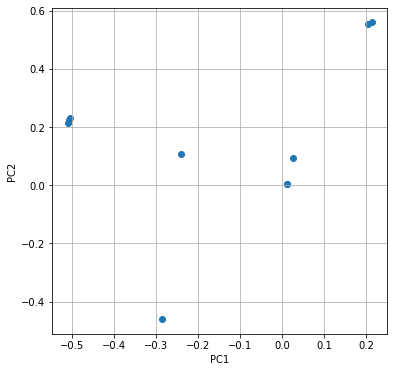

In [19]:
# 主成分負荷量を求める
df_pca = pd.DataFrame(pca_row, columns = pca_col)
df_pca_vec = pd.DataFrame(pca.components_, columns=df_workers.columns,
                          index=["PC{}".format(x + 1) for x in range(len(df_pca.columns))])
print(df_pca_vec)

# 主成分負荷量を図示する
plt.figure(figsize=(6, 6))
#for x, y, name in zip(pca.components_[0], pca.components_, df_workers.columns[0:]):
#    plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1])
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [11]:
'''
samplingしたデータを
'''

array([[-5.07281823e-01,  2.13337266e-01, -2.41489742e-01,
         2.42436767e-02, -2.85279548e-01,  2.03204605e-01,
        -5.04563598e-01, -5.10632862e-01,  1.09643856e-02,
         1.09643856e-02],
       [ 2.23905020e-01,  5.59406787e-01,  1.08417055e-01,
         9.20449937e-02, -4.59917125e-01,  5.53332740e-01,
         2.31216969e-01,  2.13275804e-01,  5.25883523e-03,
         5.25883523e-03],
       [ 6.69265749e-03, -9.97348959e-03,  2.32700157e-03,
        -1.55349678e-02,  2.02630863e-03, -7.70215791e-03,
         6.65650426e-03,  6.92979845e-03,  7.06913441e-01,
         7.06913441e-01],
       [-3.63711440e-02, -3.16964069e-02,  1.56724350e-01,
         9.79646637e-01,  9.48306726e-02, -3.88451230e-02,
        -3.82552999e-02, -3.49054617e-02,  1.04585392e-02,
         1.04585392e-02],
       [ 1.53914596e-01, -4.32015240e-02, -9.43544767e-01,
         1.71912657e-01, -7.23702816e-02, -4.60076762e-02,
         1.54713195e-01,  1.52714333e-01,  7.84733745e-04,
         7.